<a href="https://colab.research.google.com/github/harperd/machine-learning/blob/master/notebooks/simple-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Linear Regression

Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You need to figure out what the expected profit of a new food truck might be given only the population of the city that it would be placed in.

In [0]:
!pip install plotly

In [0]:
# https://plot.ly/python/getting-started/
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='rharper74@gmail.com', api_key='KzwdDa6shFfpQaAwSITY')

In [0]:
  from IPython.display import Math
  from google.colab.output._publish import javascript 

In [0]:
def print_latex(s):
  javascript(url = 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default')
  return Math(s)

In [0]:
# NumPy adds support for large, multi-dimensional arrays and matrices, along with a large collection 
# of high-level mathematical functions to operate on these arrays.
import numpy as np

# Matplotlib is a plotting library for the Python programming language and its numerical mathematics 
# extension NumPy. It provides an object-oriented API for embedding plots into applications using 
# general-purpose GUI toolkits like Tkinter, wxPython, Qt, or GTK+.
import matplotlib.pyplot as plt

# Allow saving our graphs in the notebook
%matplotlib inline

# Pandas is a software library for data manipulation and analysis. In particular, it offers data 
# structures and operations for manipulating numerical tables and time series.
import pandas as pd

In [5]:
df_raw = pd.read_csv(
    'https://raw.githubusercontent.com/harperd/machine-learning/master/data/ex1data1.csv',
    header = None,
    names=[ 'Population', 'Profit' ])
%time print(f'{len(df_raw.index):,} rows read.')

97 rows read.
CPU times: user 638 µs, sys: 0 ns, total: 638 µs
Wall time: 537 µs


In [0]:
df_raw.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [85]:
df_raw.describe()

,Bias,Population,Profit
count,97.0,97.000000,97.000000
mean,1.0,8.159800,5.839135
std,0.0,3.869884,5.510262
min,1.0,5.026900,-2.680700
25%,1.0,5.707700,1.986900
50%,1.0,6.589400,4.562300
75%,1.0,8.578100,7.046700
max,1.0,22.203000,24.147000


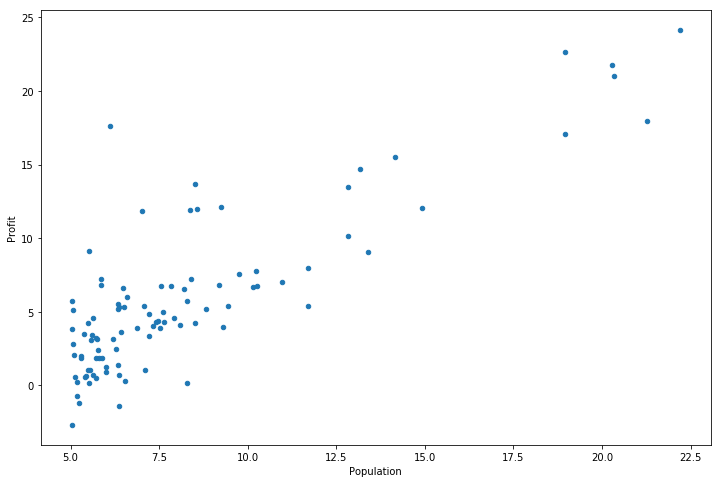

In [0]:
df_raw.plot(kind = 'scatter', x = 'Population', y = 'Profit', figsize = (12,8))

In [6]:
# Append a bias column to the beginning
# of the DataFrame. This will be used when computing
# the hypothesis using matrix multiplication.
if 'Bias' not in df_raw:
  # Insert new column at index 0, with name Bias and
  # a value of all ones.
  df_raw.insert(0, 'Bias', 1)
  
df_raw.head()

,Bias,Population,Profit
0,1,6.1101,17.5920
1,1,5.5277,9.1302
2,1,8.5186,13.6620
3,1,7.0032,11.8540
4,1,5.8598,6.8233


In [151]:
# Set X (independent/training variable) 
# and y (dependent/target variable)
cols = df_raw.shape[1]

# Get all rows and the first two columns of our DataFrame and assign to X.
X = df_raw.iloc[:, 0:cols - 1]

# Get the last column of our DataFrame and assign to y.
y = df_raw.iloc[:, cols - 1:cols]

# Convert from DataFrames to numpy matrices for easier
# calculations.
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([ 0, 0 ]))

X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

$\large J( \theta _{0} ,\ \theta _{1}) =\frac{1}{2m}\sum\limits ^{m}_{i=1}\left( h_{\theta }\left( x^{( i)}\right) -y^{( i)}\right)^{2}$

In [0]:
 def compute_cost(X, y, theta):
  # h(x)
  # Calculate predictions, h(x), with current theta values.
  # Here we are doing matrix multiplication as 
  # X multiplied by theta transposed.
  predictions = X * theta.T

  # h(x) - y
  # Get the error which tells us how far off our
  # preditions are from the dependent variables.
  error = predictions - y
  
  # sum( (h(x) - y)^2 )
  # Get the sum square error.
  sum_square_error = np.sum(np.square(error))
  
  # 1/2m * sum( (h(x) - y)^2 )
  # Compute the cost.
  m = len(y)
  cost = sum_square_error / ( 2 * m )
  
  return cost

In [11]:
print_latex(r'\text{Cost with a }\theta_0\text{ of }' + str(theta[0,0]) + r'\text{ and }\theta_1\text{ of }'+ str(theta[0,1]) + r'\text{ is }' + str(compute_cost(X, y, theta)))

<IPython.core.display.Math object>

*repeat until convergence {* 

​	$temp 0:= \theta_{0}-\alpha\frac{1}{m}\sum\limits ^{m}_{i=1}\left( h_{\theta }\left( x^{(i)}\right) -y^{( i)}\right)$

​	$temp1 := \theta_{1}-\alpha\frac{1}{m}\sum\limits ^{m}_{i=1}\left( h_{\theta }\left( x^{(i)}\right) -y^{( i)}\right)\cdot x^{(i)}$

​	$\theta_{0} := temp0$

​	$\theta_{1} := temp1$

*}* 

In [0]:
def gradient_descent(X, y, theta, alpha, iter = None):
    temp = np.array(np.zeros(theta.shape))
    m = len(y)
    cost_history = []
    theta_history = []
    cost = 0
    iterations = 0
    converged = False
    
    # Keep calculating new theta values until we have converged
    # at the minimum.
    while not converged:
      # Calculate predictions, h(x), with current theta values.
      predictions = X * theta.T

      # Get the error which tells us how far off we are from the
      # actual/dependent variables.
      error = predictions - y

      # Get feature data without bias column.
      x = X[:,1]

      # Calculate new theta values.
      temp[0,0] = theta[0,0] - ( alpha * ( np.sum(error) / m ) )
      temp[0,1] = theta[0,1] - ( alpha * ( np.sum(np.multiply(error, x)) / m ) )

      theta = temp

      # Compute the cost.
      cost = compute_cost(X, y, theta)

      if(cost == float('inf')):
        print('ERROR: The learning rate, alpha, is too large.')
        print()
        break;

      # Check for convergence.
      # If the previous cost is the same as the current cost then
      # we have converged to the minimum.
      if ((iter != None and iter == iterations) or 
          (iterations > 0 and cost_history[iterations - 1] == cost)):
        converged = True
      else:
        # Increase the number of iterations
        iterations = iterations + 1
        # Track our cost history. We will graph this to see how cost
        # decreases with the number of iterations.
        cost_history.append(cost)
        theta_history.append([theta[-1, 0], theta[-1, 1]])
      
    return np.matrix(theta_history), cost_history, iterations

In [99]:
# Run gradent descent and calculate the optimal theta values with the
# minimal cost which will draw a line that directly interstects our data.
thetas, costs, iterations = gradient_descent(X, y, theta, alpha = .01, iter = None)

theta0 = thetas[-1][0, 0]
theta1 = thetas[-1][0, 1]

print(f'Optimal theta values: {theta0} and {theta1}')
print(f'Minimum Cost........: {costs[-1]}')
print(f'Iterations..........: {iterations:,}')
print('')
%time

Optimal theta values: -3.8957786411998763 and 1.19303341944743
Minimum Cost........: 4.4769713759756335
Iterations..........: 7,976

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [156]:
MINE = True

# ---------------------------[ MINE ]----------------------------------
if MINE:
  # Set X (independent/training variable) 
  # and y (dependent/target variable)
  cols = df_raw.shape[1]

  # Get all rows and the first two columns of our DataFrame and assign to X.
  X = df_raw.iloc[:, 0:cols - 1]

  # Get the last column of our DataFrame and assign to y.
  y = df_raw.iloc[:, cols - 1:cols]

  # Convert from DataFrames to numpy matrices for easier
  # calculations.
  X = np.matrix(X.values)
  y = np.matrix(y.values)
  theta = np.matrix(np.array([ 0, 0 ]))

  thetas, costs, iterations = gradient_descent(X, y, theta, alpha = .01, iter = None)
  theta = np.array([thetas[-1][0,0], thetas[-1][0,1]])
  xaug = np.array(X)
  history=[ np.array(t)[0] for t in thetas ]
else:
  # ---------------------------[ THEIRS ]----------------------------------
  from sklearn.datasets.samples_generator import make_regression 
  
  x, y = make_regression(n_samples = 100, 
                         n_features=1, 
                         n_informative=1, 
                         noise=20,
                         random_state=2017)
  x = x.flatten()
  xaug = np.c_[np.ones(x.shape[0]), x]
  theta_i = [-15, 40] + np.random.rand(2)
  history, costs, preds, iters = gd(xaug, y, theta_i, step=0.1)

# ------------------------------------------------------------------------

# https://gist.github.com/felipessalvatore/c2e1c09dfcb8710b847e2457620f8204
from mpl_toolkits.mplot3d import Axes3D

costs
#theta = history[-1]

# Numpy linespace returns evenly spaced numbers over a specified interval.
#ms = np.linspace(theta[1] - 20 , theta[1] + 20, 20)
#bs = np.linspace(theta[0] - 40 , theta[0] + 40, 40)

# Numpy meshgrid returns coordinate matrices from coordinate vectors.
# We want to create create a rectangular array of ms and bs values.
#M, B = np.meshgrid(ms, bs)

# Numpy ravel returns a contiguous flattened 1-D array, containing the elements
# of the input, is returned.
#zs = np.array([
#  compute_cost(xaug, y, np.matrix(theta)) for theta in zip(np.ravel(M), np.ravel(B))
#])

#Z = zs.reshape(M.shape)

#fig = plt.figure(figsize=(20, 10))
#ax = fig.add_subplot(111, projection='3d')

# Plot our 3D surface
#ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
#ax.set_xlabel(r'$\theta_0$', labelpad=30, fontsize=24, fontweight='bold')
#ax.set_ylabel(r'$\theta_1$', labelpad=30, fontsize=24, fontweight='bold')
#ax.set_zlabel(r'$J(\theta_0,\theta_1)$', labelpad=30, fontsize=24, fontweight='bold')
#ax.view_init(elev=20., azim=0)

# Show a red dot at the minimum
#ax.plot([theta[0]], [theta[1]], [costs[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)
#ax.plot([history[0][0]], [history[0][1]], [costs[0]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)

#ax.plot([t[0] for t in history], [t[1] for t in history], costs , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2)
#ax.plot([t[0] for t in history], [t[1] for t in history], 0 , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2)

#fig.suptitle("Minimizando f(x1,x2)", fontsize=24, fontweight='bold')

[6.737190464870007,
 5.931593568604956,
 5.901154707081388,
 5.895228586444221,
 5.89009494311733,
 5.885004158443647,
 5.879932480491418,
 5.874879094762575,
 5.869843911806386,
 5.8648268653129305,
 5.859827889932181,
 5.85484692057229,
 5.849883892376588,
 5.844938740722034,
 5.840011401218361,
 5.8351018097072265,
 5.830209902261388,
 5.825335615183863,
 5.820478885007099,
 5.815639648492154,
 5.81081784262787,
 5.806013404630044,
 5.801226271940628,
 5.796456382226899,
 5.7917036733806535,
 5.786968083517396,
 5.782249550975539,
 5.777548014315596,
 5.772863412319381,
 5.768195683989212,
 5.76354476854712,
 5.758910605434049,
 5.754293134309077,
 5.749692295048629,
 5.745108027745684,
 5.740540272709014,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333528,
 5.713477184364749,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.695757917651815,
 5.691367918863752,
 5.68699373259798,
 5.682635301898707,
 5.678292570015292,
 5

Gradient Descent: -3.73, 82.80 73
Least Squares: -3.71, 82.90


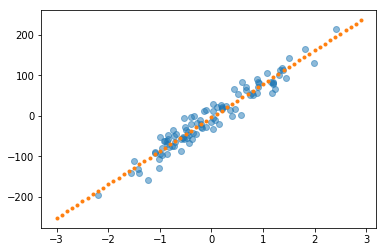

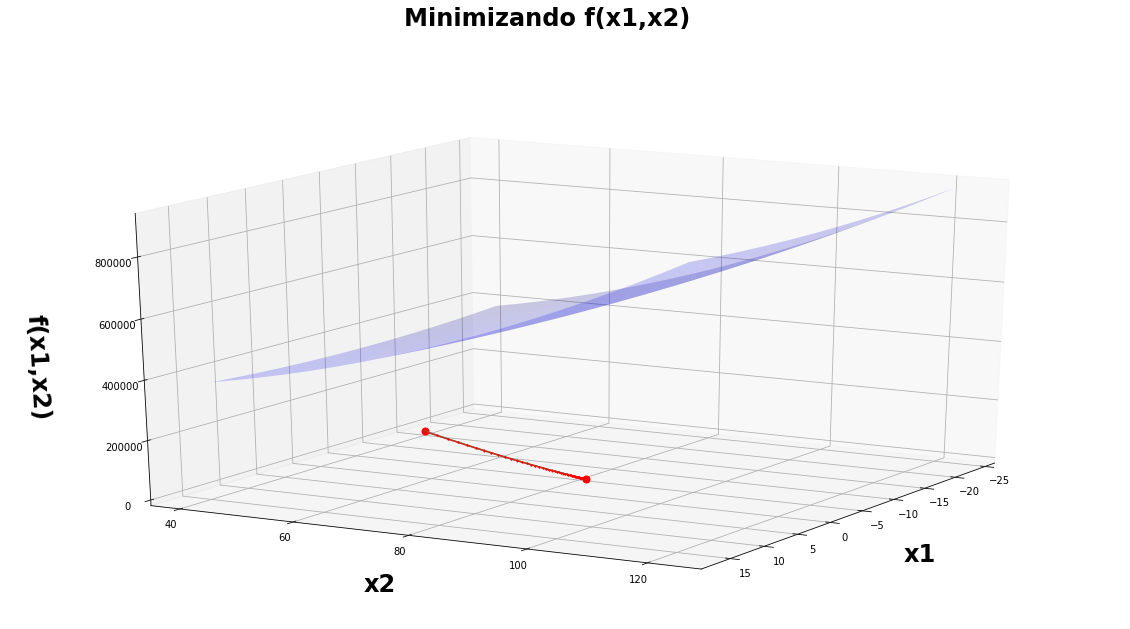

In [112]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats 

from sklearn.datasets.samples_generator import make_regression 



x, y = make_regression(n_samples = 100, 
                       n_features=1, 
                       n_informative=1, 
                       noise=20,
                       random_state=2017)
x = x.flatten()
slope, intercept, _,_,_ = stats.linregress(x,y)
best_fit = np.vectorize(lambda x: x * slope + intercept)
plt.plot(x,y, 'o', alpha=0.5)
grid = np.arange(-3,3,0.1)
plt.plot(grid,best_fit(grid), '.')

def gd(x, y, theta_init, step=0.001, maxsteps=0, precision=0.001, ):
    costs = []
    m = y.size # number of data points
    theta = theta_init
    history = [] # to store all thetas
    preds = []
    counter = 0
    oldcost = 0
    pred = np.dot(x, theta)
    error = pred - y 
    currentcost = np.sum(error ** 2) / (2 * m)
    preds.append(pred)
    costs.append(currentcost)
    history.append(theta)
    counter+=1
    while abs(currentcost - oldcost) > precision:
        oldcost=currentcost
        gradient = x.T.dot(error)/m 
        theta = theta - step * gradient  # update
        history.append(theta)
        
        pred = np.dot(x, theta)
        error = pred - y 
        currentcost = np.sum(error ** 2) / (2 * m)
        costs.append(currentcost)
        
        if counter % 25 == 0: preds.append(pred)
        counter+=1
        if maxsteps:
            if counter == maxsteps:
                break
        
    return history, costs, preds, counter
xaug = np.c_[np.ones(x.shape[0]), x]
theta_i = [-15, 40] + np.random.rand(2)
history, cost, preds, iters = gd(xaug, y, theta_i, step=0.1)
theta = history[-1]
print("Gradient Descent: {:.2f}, {:.2f} {:d}".format(theta[0], theta[1], iters))
print("Least Squares: {:.2f}, {:.2f}".format(intercept, slope))


from mpl_toolkits.mplot3d import Axes3D

def error(X, Y, THETA):
    return np.sum((X.dot(THETA) - Y)**2)/(2*Y.size)

ms = np.linspace(theta[0] - 20 , theta[0] + 20, 20)
bs = np.linspace(theta[1] - 40 , theta[1] + 40, 40)

M, B = np.meshgrid(ms, bs)

zs = np.array([ecmprror(xaug, y, theta) 
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
#ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)


ax.set_xlabel('x1', labelpad=30, fontsize=24, fontweight='bold')
ax.set_ylabel('x2', labelpad=30, fontsize=24, fontweight='bold')
ax.set_zlabel('f(x1,x2)', labelpad=30, fontsize=24, fontweight='bold')
ax.view_init(elev=20., azim=30)
ax.plot([theta[0]], [theta[1]], [cost[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)
ax.plot([history[0][0]], [history[0][1]], [cost[0]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)


ax.plot([t[0] for t in history], [t[1] for t in history], cost , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2)
ax.plot([t[0] for t in history], [t[1] for t in history], 0 , markerfacecolor='r', markeredgecolor='r', marker='.', markersize=2)

fig.suptitle("Minimizando f(x1,x2)", fontsize=24, fontweight='bold')
plt.savefig("Minimization_image.png")

Text(0.5, 1.0, 'Predicted Profit vs. Population Size')

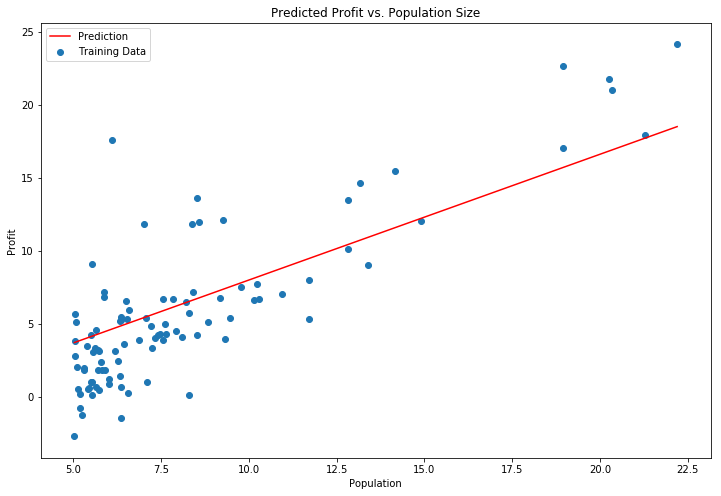

In [0]:
## Return evenly spaced numbers over a specified interval of 100.
x = np.linspace(df_raw.Population.min(), df_raw.Population.max(), 100)
f = optimal_theta0 + (optimal_theta1 * x)

fig, ax = plt.subplots(figsize = (12,8))

ax.plot(x, f, 'r', label='Prediction')
ax.scatter(df_raw.Population, df_raw.Profit, label='Training Data')
ax.legend(loc = 2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')

Text(0.5, 1.0, 'Error vs. Training Epoch')

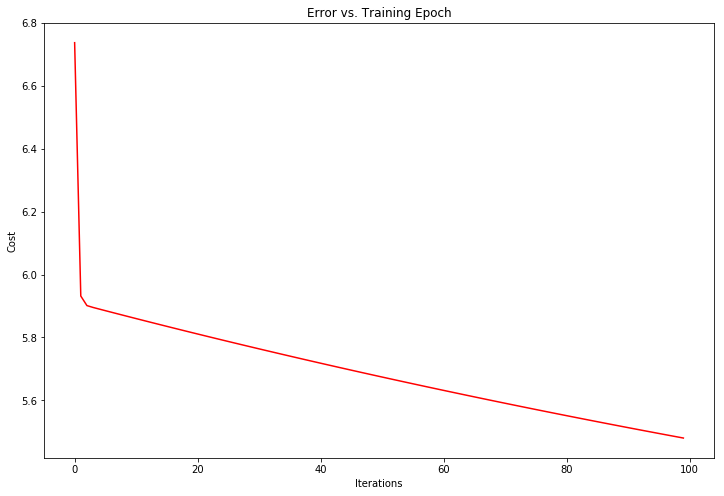

In [0]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iterations), costs, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')